In [ ]:
%reset -f
# Sheet metal gauge reference: https://armstrongmetalcrafts.com/reference/SheetMetalGaugeWeight.aspx

# Manufacturing capabilities per value stream @ BAC
This code shows conservative boundaries for the allowed dimensions in each manufacturing value stream.

In [9]:
from capabilities import Capabilities
import pandas as pd
import numpy as np
import xlwings as xw
import os

Extracting dimensions from cost calculator. CWB example to start with.

In [9]:
path_e = r"C:\Users\EMedina\OneDrive - Baltimore Aircoil Company\Documents\Co-Op\Enrique + Stanley\Models\Cost\(Enrique, Stanley) APB-TL Part Cost Calculator.xlsx"
path_s = r"C:\Users\ssalim\OneDrive - Baltimore Aircoil Company\Medina, Enrique Flores's files - Enrique + Stanley\Models\Cost\(Enrique, Stanley) APB-TL Part Cost Calculator.xlsx"
path = path_e if os.path.exists(path_e) else path_s
df = pd.read_excel(path, sheet_name='BAC Part List').iloc[1:].reset_index(drop=True)
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)

c:\Users\ssalim\AppData\Local\anaconda3\envs\bac\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [10]:
def get_parts_by_set(df, part_set):
    if isinstance(part_set, str): part_set = [part_set]
    return df[df['Part Set'].isin(part_set)].copy()

part_sets = []
for part_set in df['Part Set'].dropna().unique(): part_sets.append(get_parts_by_set(df, part_set))
# part_sets.append(get_parts_by_set(df, 'GAC Reference (MPB)'))
# part_sets.append(get_parts_by_set(df, 'GAC Concept (APB + TL)'))

# Plot manufacturing regions per material and gauge

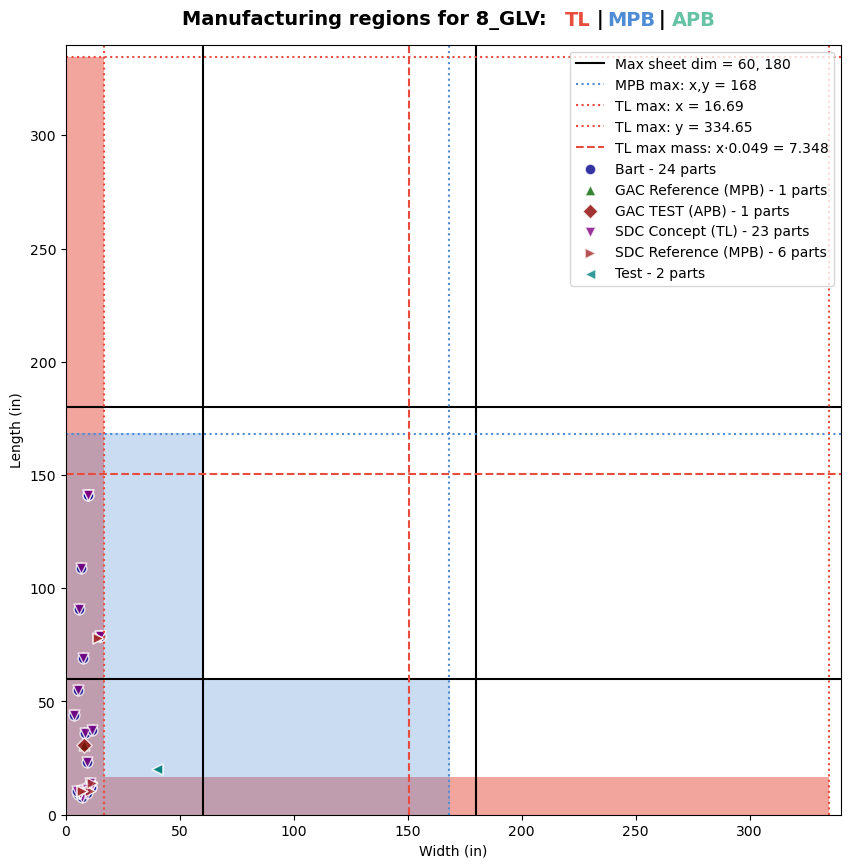

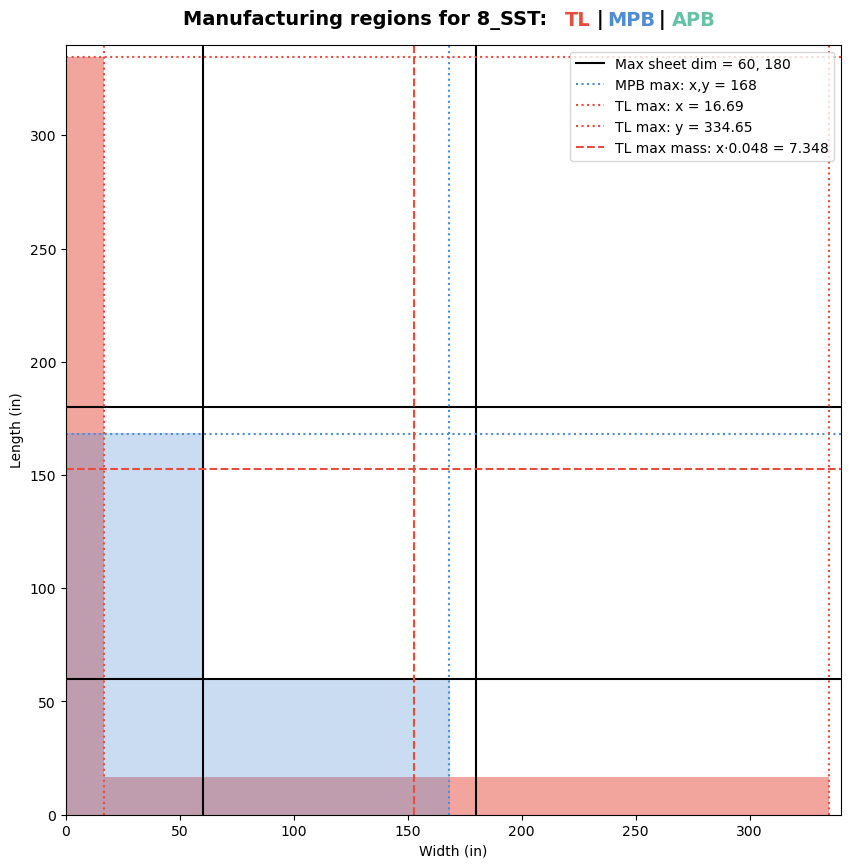

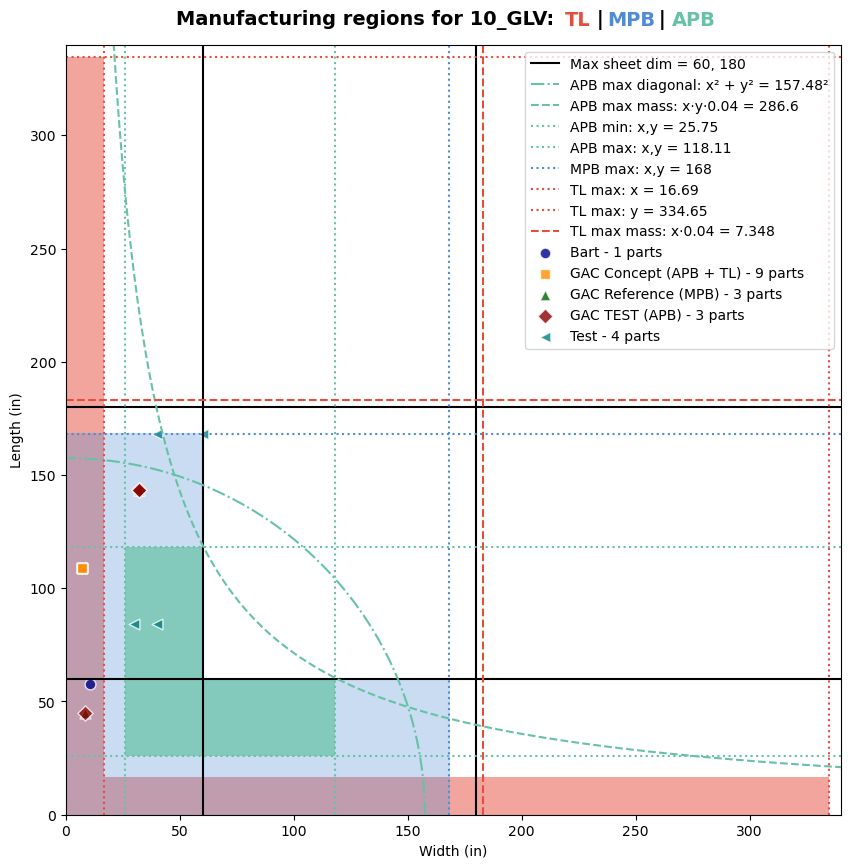

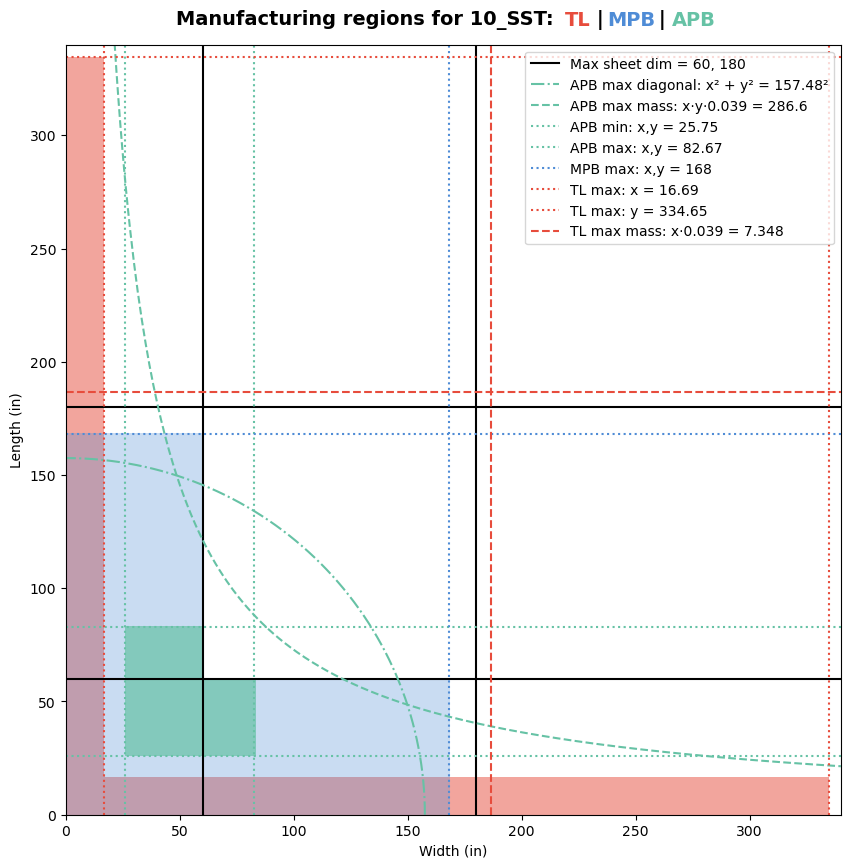

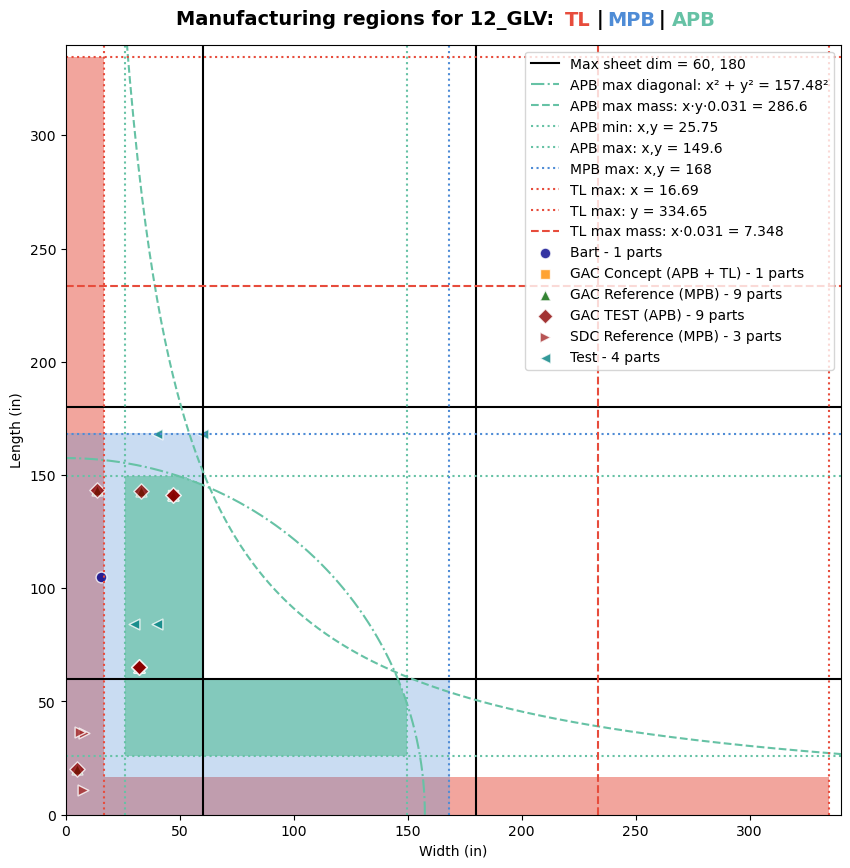

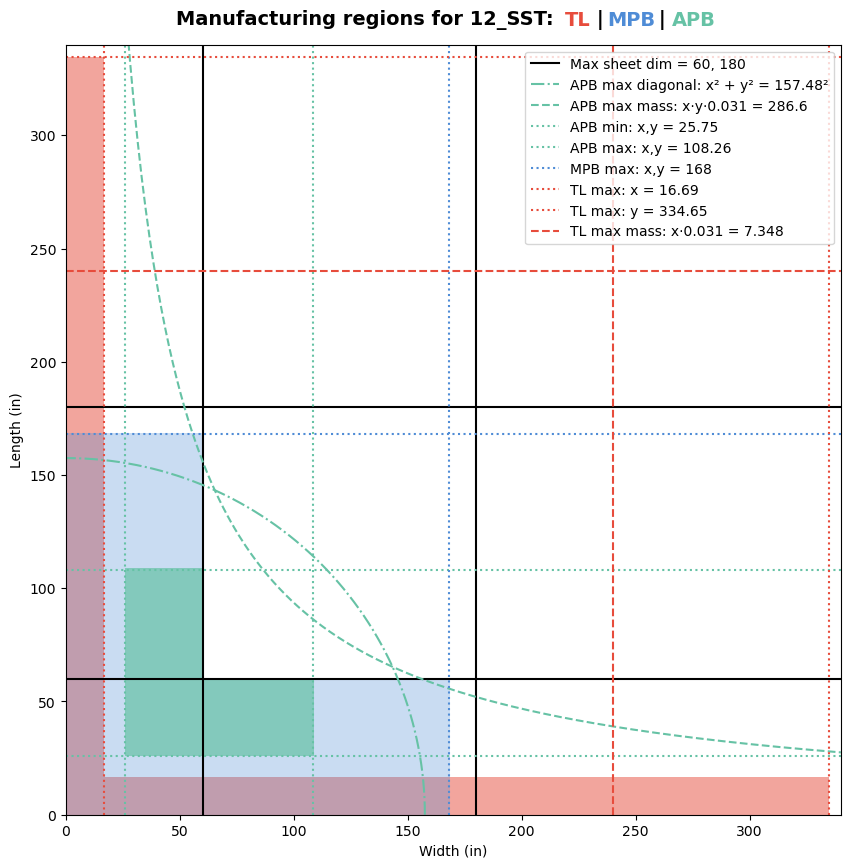

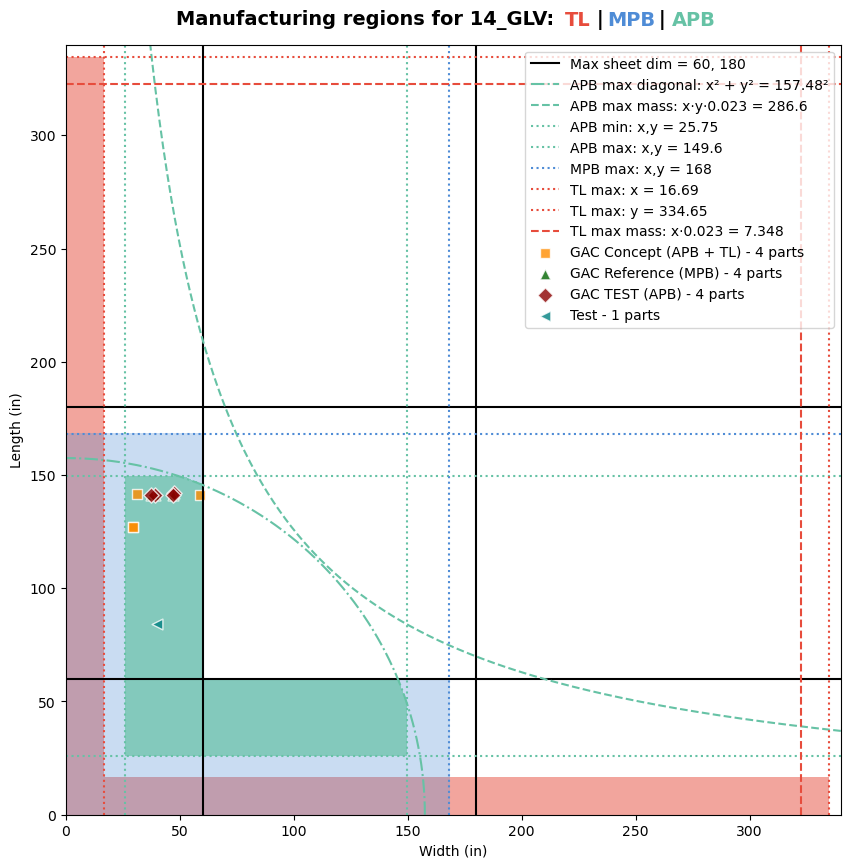

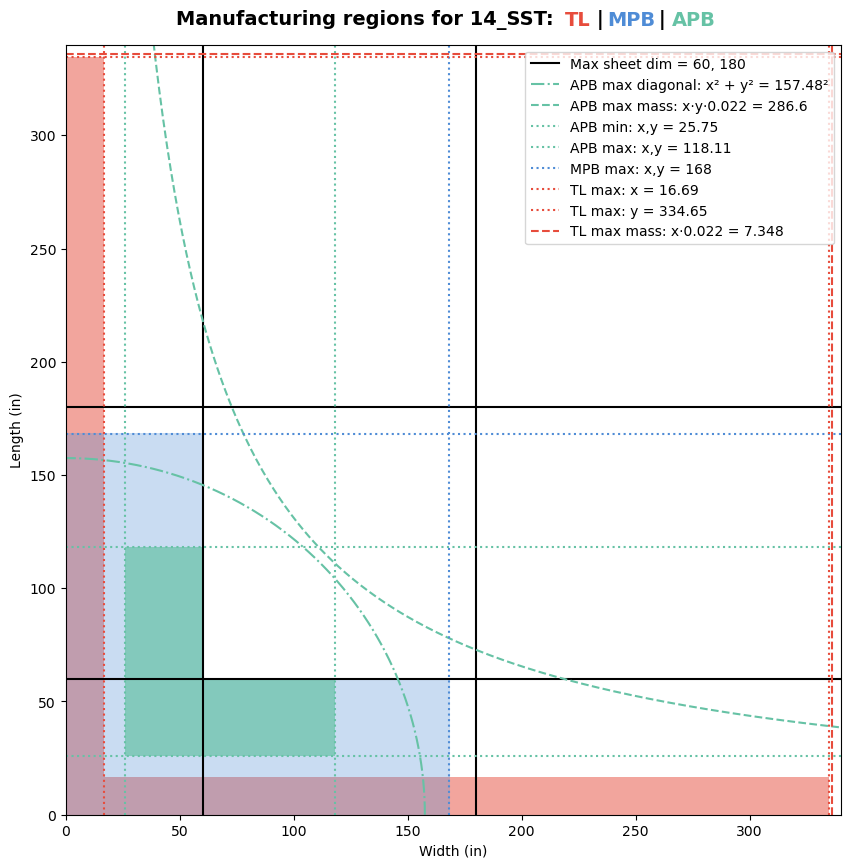

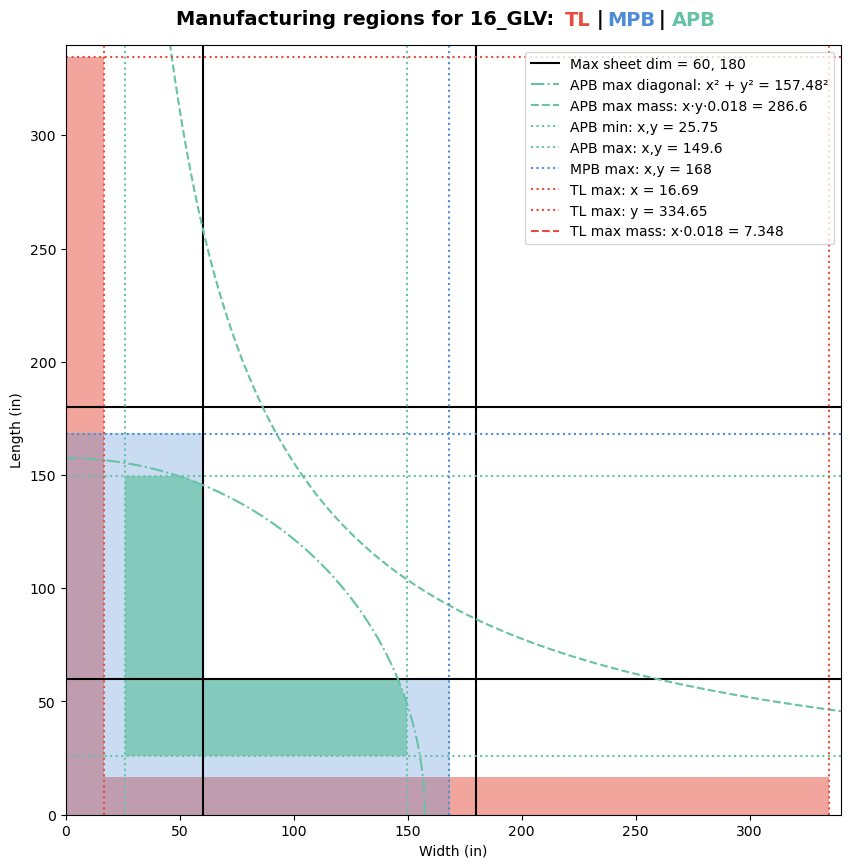

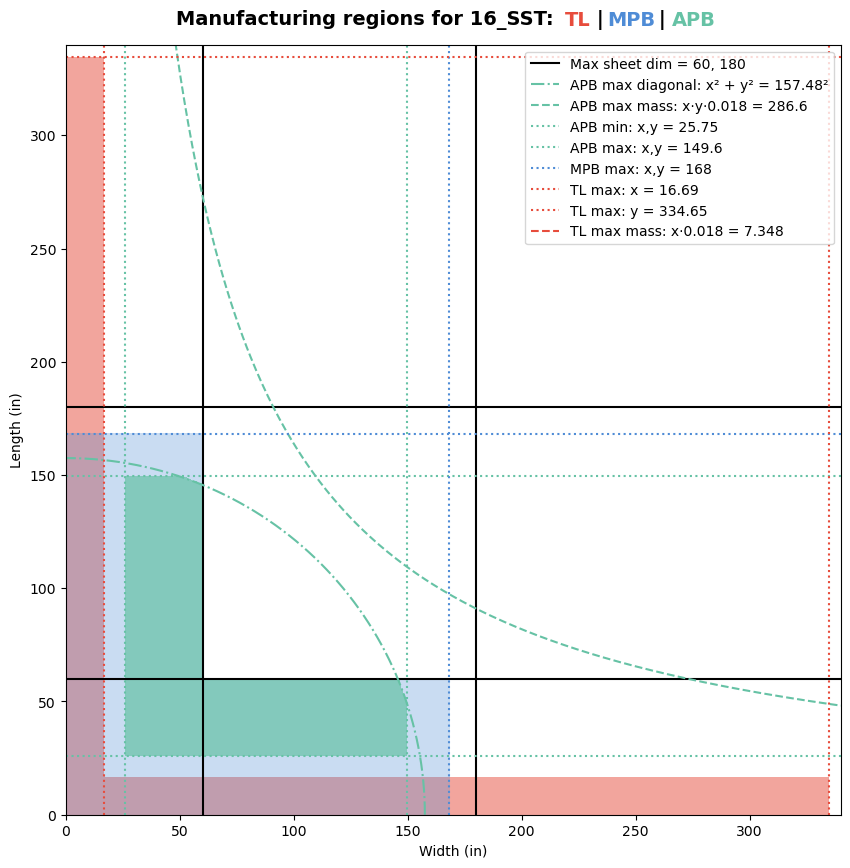

In [11]:
gauges = [8, 10, 12, 14, 16]
materials = ['GLV', 'SST']

# Plot all combinations
for gauge in gauges:
    for material in materials:
        cap = Capabilities(material, gauge)
        cap.plot_feasible_regions()
        cap.add_part_sets(part_sets)

Starting cost run chart generation...
Parameters: diagonal direction from (5, 5) to (55, 55)
Spacing: 5, Fastener spacing: 3
Generated 11 path points
Calculating feasible combinations...
  Point 1: (5.0, 5.0) -> ['MPB', 'TL']
  Point 2: (10.0, 10.0) -> ['MPB', 'TL']
  Point 3: (15.0, 15.0) -> ['MPB', 'TL']
  Point 4: (20.0, 20.0) -> ['MPB']
  Point 5: (25.0, 25.0) -> ['MPB']
  Point 6: (30.0, 30.0) -> ['MPB', 'APB']
  Point 7: (35.0, 35.0) -> ['MPB', 'APB']
  Point 8: (40.0, 40.0) -> ['MPB', 'APB']
  Point 9: (45.0, 45.0) -> ['MPB', 'APB']
  Point 10: (50.0, 50.0) -> ['MPB', 'APB']
  Point 11: (55.0, 55.0) -> ['MPB', 'APB']
Total feasible combinations: 20
Preparing batch inputs...
Prepared 20 calculations for batch processing
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 169...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 20 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Processing re

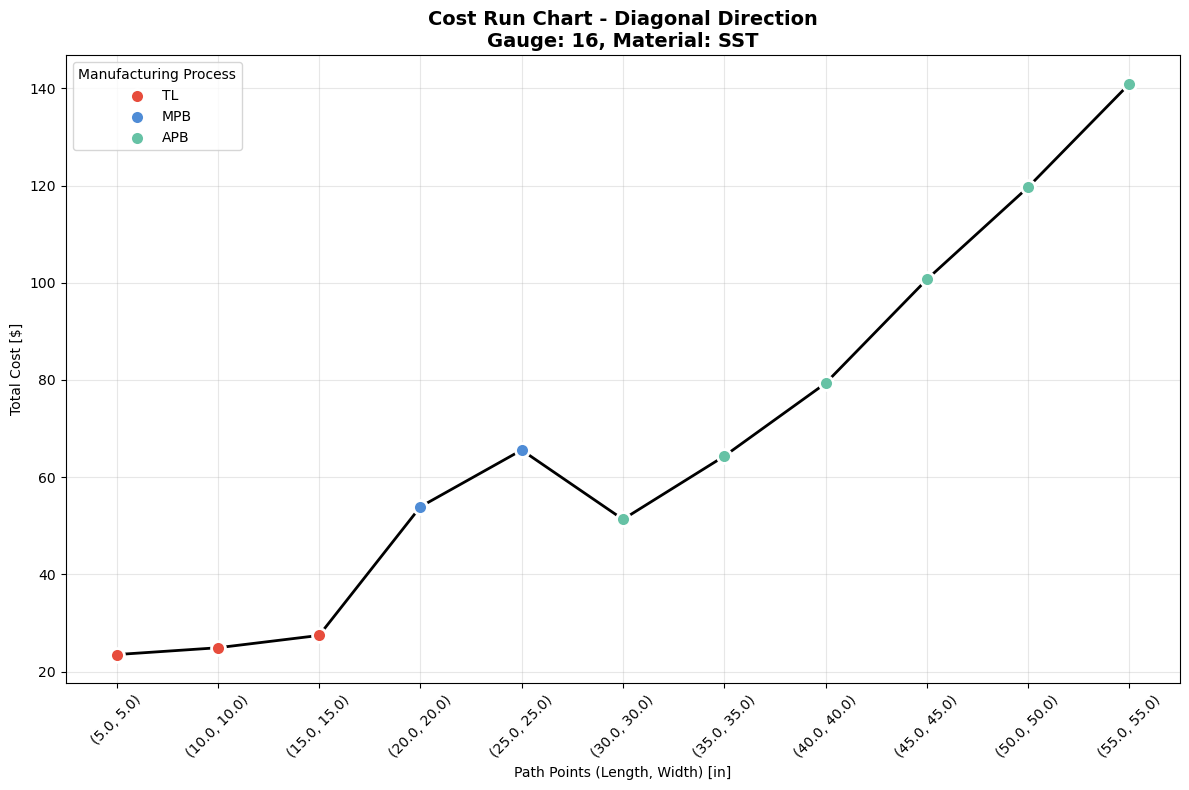


Cost Run Chart Summary:
Direction: diagonal
Range: (5.0, 5.0) to (55.0, 55.0)
Number of points: 11
Cost range: $23.50 - $140.94
Function completed successfully!
Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 287
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 436...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 287 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 520
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 669...
Calculating Excel formulas...
Excel calculation comple

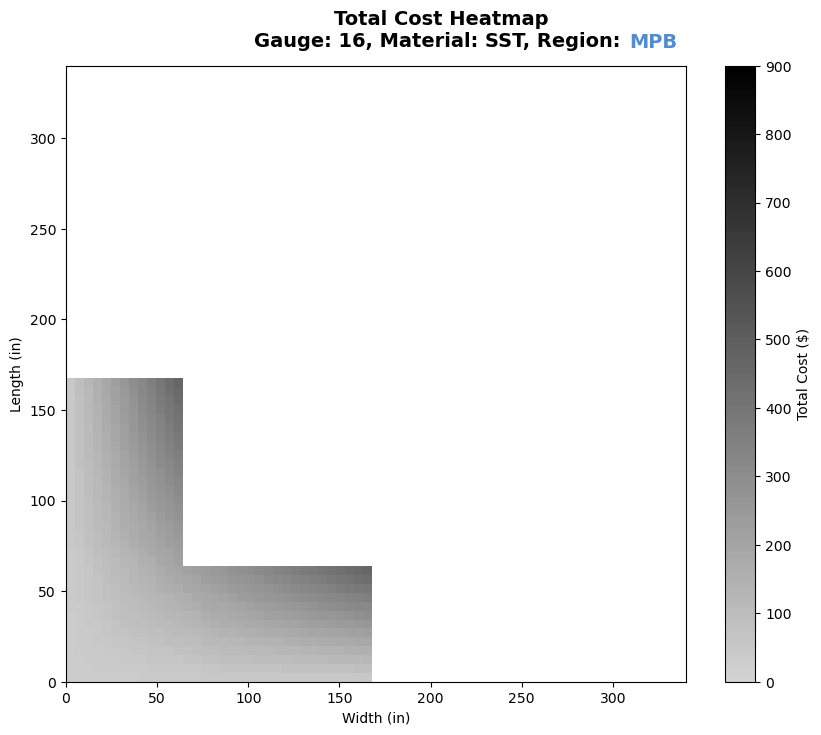

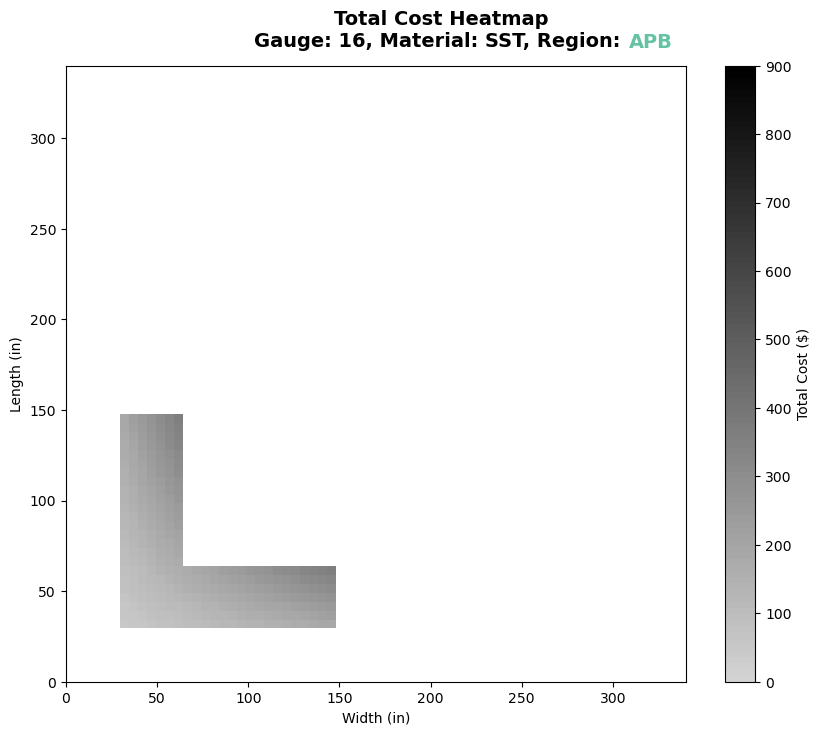

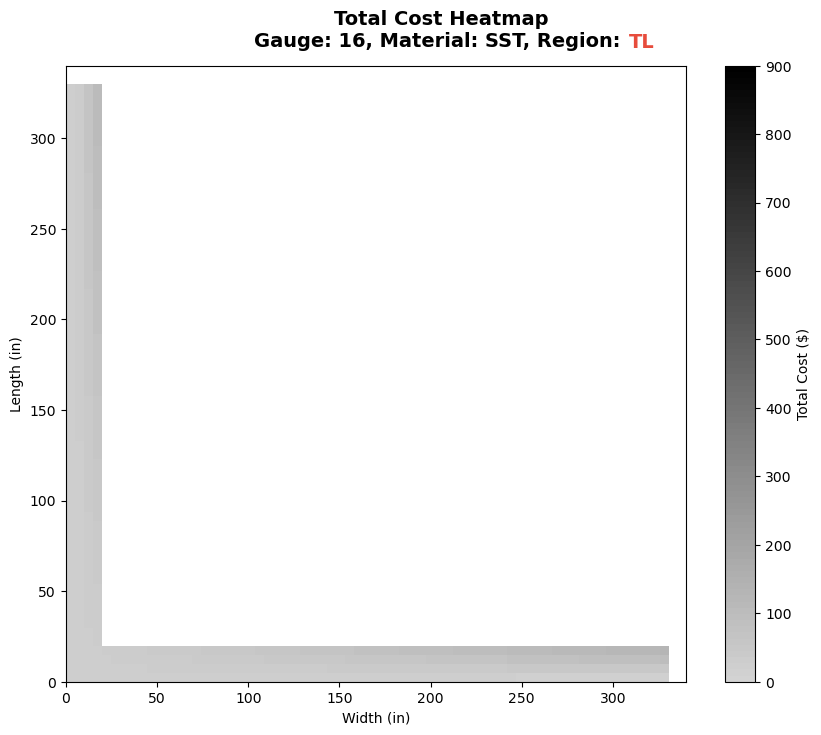

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 287
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 436...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 287 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 520
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 669...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 520 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed

COMPREHENSIVE COST STATISTICS FOR OPTIMAL REGIONS

M

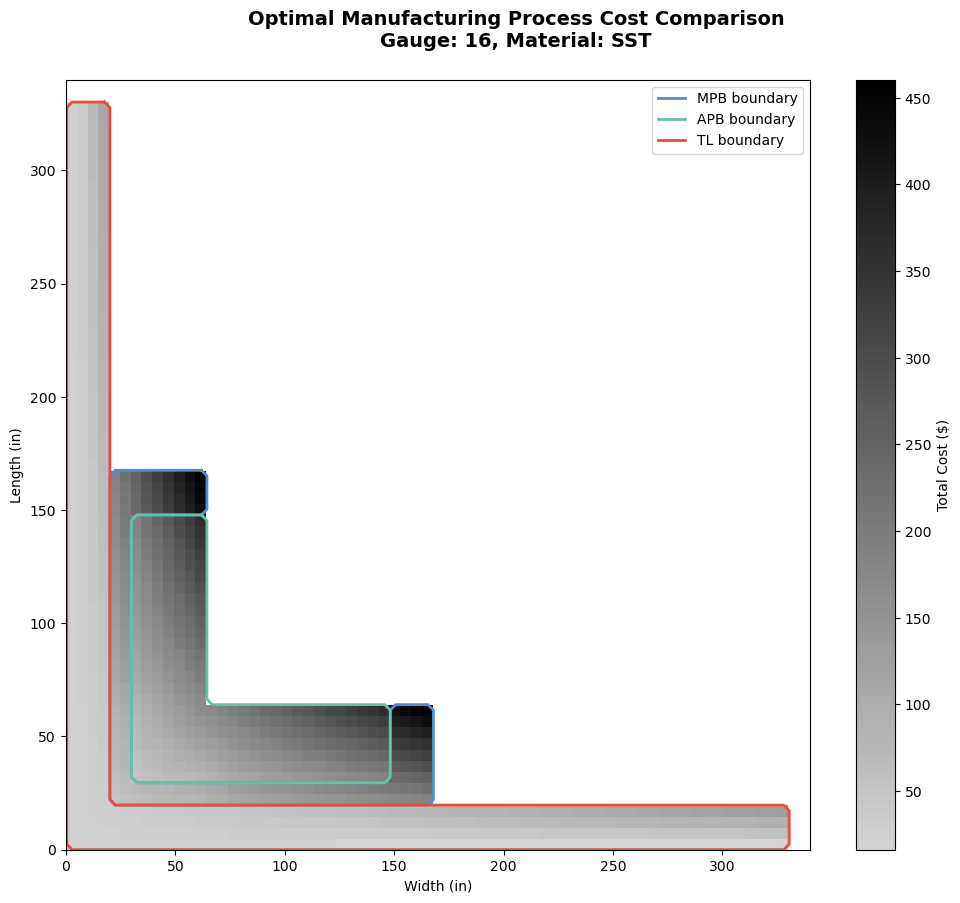

Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 287
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 436...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 287 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 520
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 669...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 520 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Analyzing regions with multiple feasible processes...

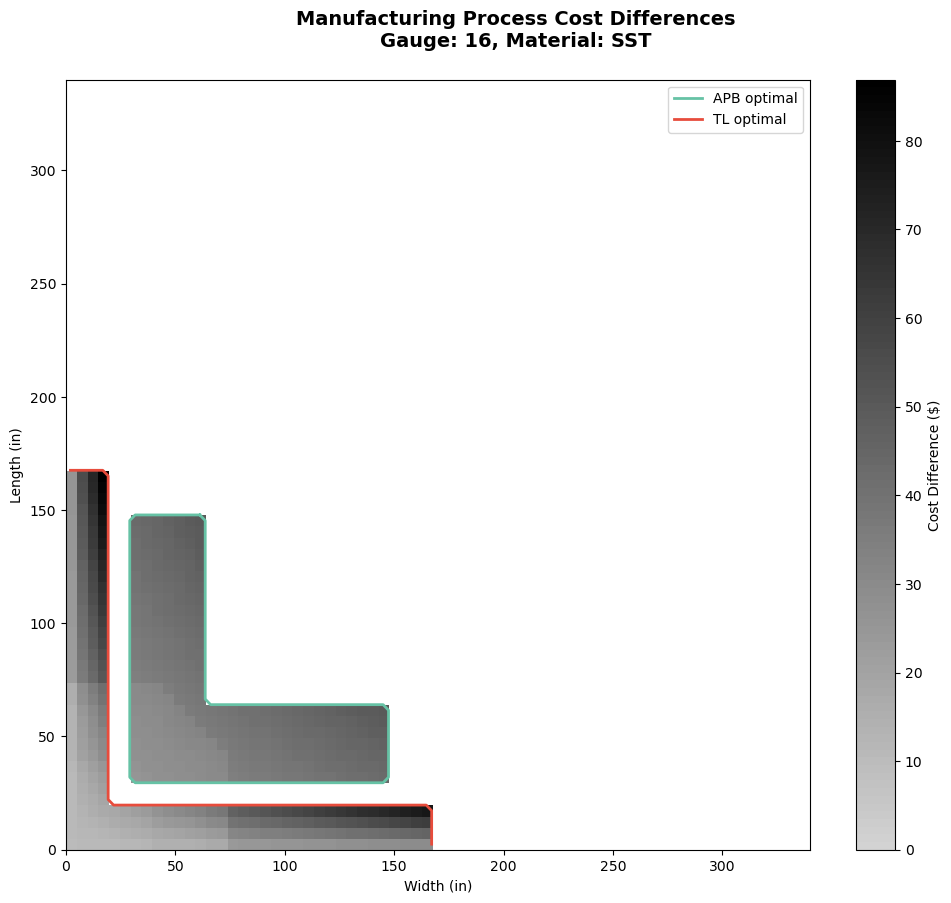

{'MPB': None,
 'APB': {'min_cost': np.float64(48.96074697549206),
  'max_cost': np.float64(359.81436469020775),
  'avg_cost': np.float64(184.30052699883197),
  'median_cost': np.float64(179.798810597732),
  'std_cost': np.float64(69.88978569820443),
  'percentile_25': np.float64(134.3295421784445),
  'percentile_75': np.float64(231.82650469887832),
  'optimal_points': 287,
  'optimal_area_sq_in': 6968.536021844149,
  'cost_per_sq_in': np.float64(7.590439524579923),
  'win_rate': np.float64(52.85451197053407),
  'min_advantage': np.float64(26.04652975405837),
  'max_advantage': np.float64(50.2377225301571),
  'avg_advantage': np.float64(38.866496137644575),
  'median_advantage': np.float64(39.66062915419781),
  'std_advantage': np.float64(5.868186827287281),
  'advantage_25th': np.float64(36.078125869900674),
  'advantage_75th': np.float64(43.11678095032862)},
 'TL': {'min_cost': np.float64(19.761670299689026),
  'max_cost': np.float64(74.51067290561932),
  'avg_cost': np.float64(33.988

In [12]:
for app in xw.apps:
    app.quit()

# # Increase width from 20 to 60, keeping length at 80  
# results = cap.cost_run_chart(path, 15, 130, 15, 180, 'width', 5)

# Diagonal increase from (40,30) to (100,80)
results = cap.plot_cost_run_chart(path, 5, 5, 55, 55, 'diagonal', 5)

# cap.process_cost_difference(path, fastener_spacing, bolt_diameter)

cap.plot_individual_cost_heatmap(path, fastener_spacing=3, bolt_diameter=0.3125)
cap.plot_optimal_cost_heatmap(path, fastener_spacing=3, bolt_diameter=0.3125)
cap.plot_cost_difference_heatmap(path, fastener_spacing=3, bolt_diameter=0.3125)